In [22]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from DataFormat  import DataFormat
from read_data   import read_data
from calibration import read_calibration_parameters, linear_calibration

from matplotlib.colors import LogNorm

In [93]:
DATA_PATH   = "./data"

LABR_A  = "labr-a"
LABR_B  = "labr-b"
CLYC    = "clyc"
PLASTIC = "plastic"

RUN_DAYS = [2, 3]

In [94]:
time_windows = [50, 100, 500, 1000, 5000, 10000, 50000, 100000] # in ns

### LaBr3 A

In [95]:
# read coincidence data
labra_coincidence = pd.DataFrame(
    columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle', 'time_window', 'run_day']
)

for tw in time_windows:
    for run_day in RUN_DAYS:
        df = pd.read_csv(f"{DATA_PATH}/labra-coincidence-day{run_day}-{tw}ns.csv")
        df.loc[:, "time_window"] = tw
        df.loc[:, "run_day"]     = run_day
        labra_coincidence = labra_coincidence.append(df, ignore_index=True)
        
# place the id column at the beginning
# drop board channel flag columns
labra_coincidence = labra_coincidence[["id", "run_day", "time_window", "timestamp", "energy", "energy_short", "energy_calib", "energy_short_calib", "psd", "psd_calib", "Particle"]]

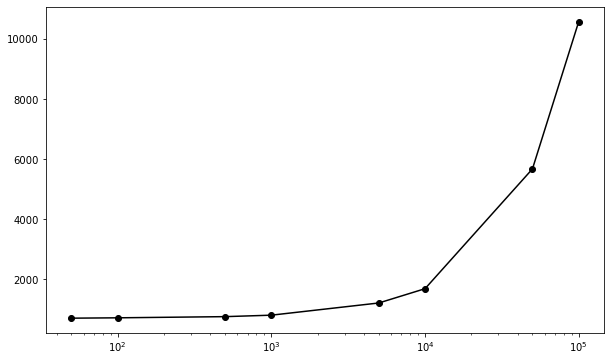

In [96]:
# for each time window count the number of Gamma coincidences and plot the number of coincidences as a function of the time window
labra_gamma = labra_coincidence[labra_coincidence["Particle"] == "Gamma"]
labra_gamma_grouped = labra_gamma.groupby("time_window").count()["id"]

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)

ax.plot(labra_gamma_grouped.index, labra_gamma_grouped.values, marker="o", color="black")
ax.set_xscale("log")

plt.show()

In [97]:
# for each time window, count how many Gamma particles are found between two Neutron particles
counts = labra_coincidence.groupby(["time_window", "run_day", "Particle"]).count()["id"]
counts

time_window  run_day  Particle
50           2        Gamma        309
                      Neutron      309
             3        Gamma        396
                      Neutron      396
100          2        Gamma        316
                      Neutron      316
             3        Gamma        401
                      Neutron      401
500          2        Gamma        332
                      Neutron      332
             3        Gamma        424
                      Neutron      424
1000         2        Gamma        353
                      Neutron      353
             3        Gamma        452
                      Neutron      452
5000         2        Gamma        563
                      Neutron      563
             3        Gamma        648
                      Neutron      648
10000        2        Gamma        812
                      Neutron      812
             3        Gamma        875
                      Neutron      874
50000        2        Gamma      

In [98]:
def count_gamma_between_neutrons(df):
    # Find the indices of the Neutron particles
    neutron_indices = df[df["Particle"] == "Neutron"].index
    # Initialize an empty list to store the counts of Gamma particles
    gamma_counts = []
    # Iterate over the indices of the Neutron particles
    for i in range(len(neutron_indices) - 1):
        # Get the start and end indices for the current time window
        start_index = neutron_indices[i]
        end_index = neutron_indices[i+1]
        # Count the number of Gamma particles in the current time window
        gamma_count = df.loc[start_index:end_index, "Particle"].value_counts()["Gamma"]
        # Append the count to the list
        gamma_counts.append(gamma_count)
    # Return the list of counts
    return gamma_counts

# Group the dataframe by the "time_window" column
grouped_df = labra_coincidence.groupby("time_window")

# Apply the count_gamma_between_neutrons function to each group
gamma_counts_by_time_window = grouped_df.apply(count_gamma_between_neutrons)


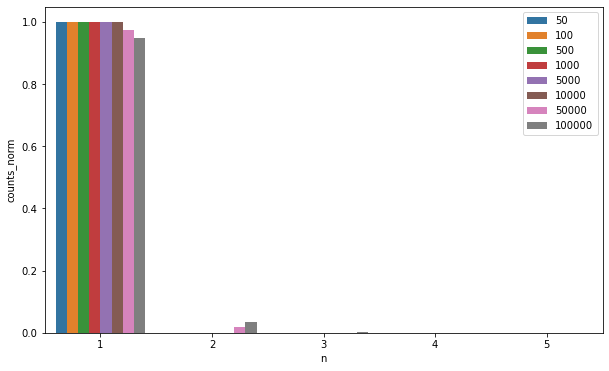

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

n_df = pd.DataFrame(columns=["time_window", "n", "counts"])

# Iterate over the time windows
for time_window, gamma_counts in gamma_counts_by_time_window.items():

    # compute how many ones there are in the gamma_counts list
    ones = gamma_counts.count(1)
    twos = gamma_counts.count(2)
    three = gamma_counts.count(3)
    four = gamma_counts.count(4)
    five = gamma_counts.count(5)
    
    n_df = n_df.append({"time_window": time_window, "n": 1, "counts": ones}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 2, "counts": twos}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 3, "counts": three}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 4, "counts": four}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 5, "counts": five}, ignore_index=True)
   
   
# normalize the counts to the total number of coincidences
for tw in time_windows:
    tot = labra_coincidence[labra_coincidence["time_window"] == tw].count()["id"]
    n_df.loc[n_df["time_window"] == tw, "counts_norm"] = n_df.loc[n_df["time_window"] == tw, "counts"] / tot * 2


ax = sns.barplot(x="n", y="counts_norm", hue="time_window", data=n_df, ax=ax) 
ax.legend()

plt.show()
    
    

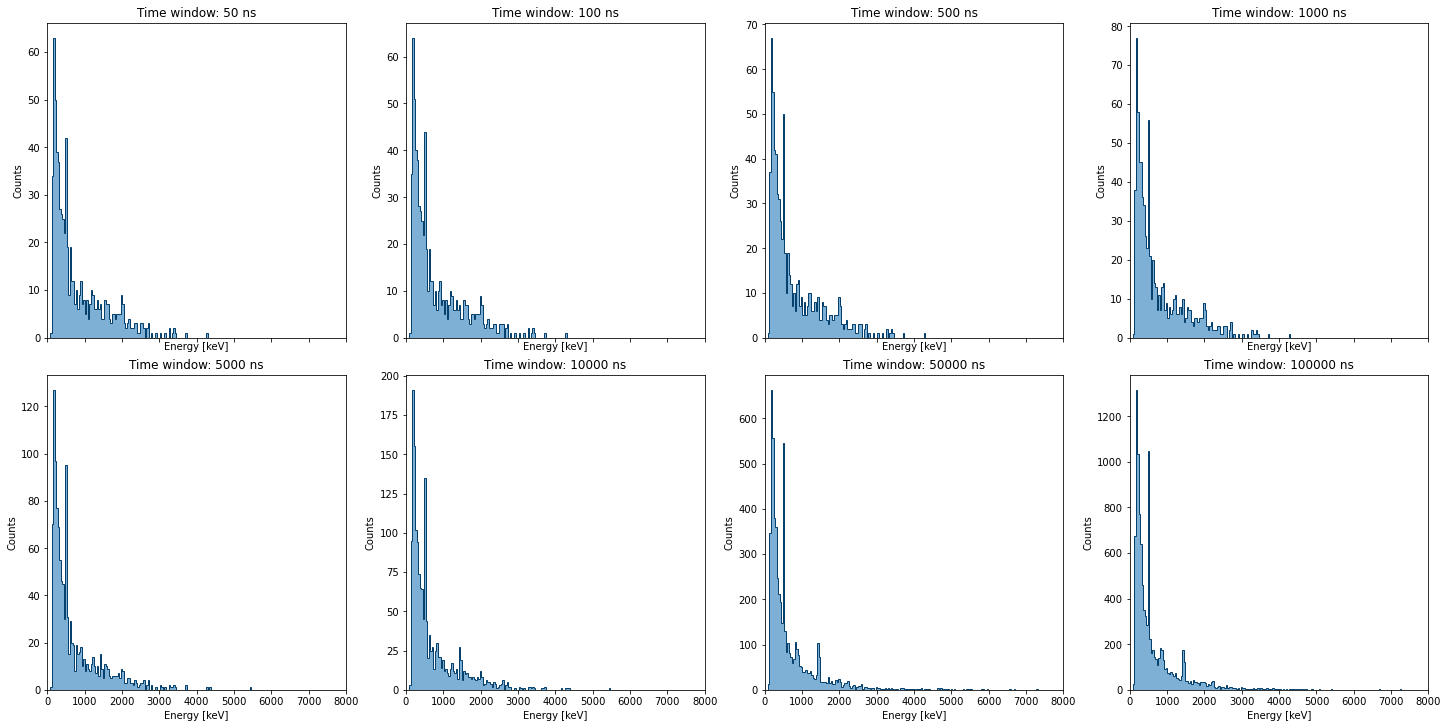

In [101]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True, sharex=True)

for i, tw in enumerate(time_windows):
    ax[i//4, i%4].hist(
        labra_gamma[labra_gamma["time_window"] == tw]["energy_calib"],
        bins      = np.linspace(0, 8000, 200), 
        histtype  = "stepfilled", 
        edgecolor = "#06416D", 
        facecolor = "#7eb0d5",
        label     = f"{tw} ns"
    )

    ax[i//4, i%4].set_xlim(0, 8000)
    ax[i//4, i%4].set_xlabel("Energy [keV]")
    ax[i//4, i%4].set_ylabel("Counts")

    ax[i//4, i%4].set_title(f"Time window: {int(tw)} ns")
    
    
fig.savefig("./plots/labra_e_hist_coincidence_windows.png", dpi=300, facecolor="white")
plt.show()


### LaBr3 B

In [102]:
# read coincidence data
labrb_coincidence = pd.DataFrame(
    columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle', 'time_window', 'run_day']
)

for tw in time_windows:
    for run_day in RUN_DAYS:
        df = pd.read_csv(f"{DATA_PATH}/labrb-coincidence-day{run_day}-{tw}ns.csv")
        df.loc[:, "time_window"] = tw
        df.loc[:, "run_day"]     = run_day
        labrb_coincidence = labrb_coincidence.append(df, ignore_index=True)
        
# place the id column at the beginning
# drop board channel flag columns
labrb_coincidence = labrb_coincidence[["id", "run_day", "time_window", "timestamp", "energy", "energy_short", "energy_calib", "energy_short_calib", "psd", "psd_calib", "Particle"]]

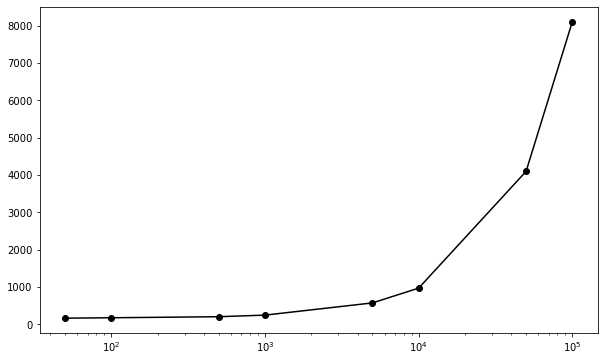

In [103]:
# for each time window count the number of Gamma coincidences and plot the number of coincidences as a function of the time window
labrb_gamma = labrb_coincidence[labrb_coincidence["Particle"] == "Gamma"]
labrb_gamma_grouped = labrb_gamma.groupby("time_window").count()["id"]

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)

ax.plot(labrb_gamma_grouped.index, labrb_gamma_grouped.values, marker="o", color="black")
ax.set_xscale("log")

plt.show()

In [104]:
# for each time window, count how many Gamma particles are found between two Neutron particles
counts = labrb_coincidence.groupby(["time_window", "run_day", "Particle"]).count()["id"]
counts


time_window  run_day  Particle
50           2        Gamma         84
                      Neutron       84
             3        Gamma         76
                      Neutron       76
100          2        Gamma         87
                      Neutron       87
             3        Gamma         84
                      Neutron       84
500          2        Gamma        103
                      Neutron      103
             3        Gamma         96
                      Neutron       96
1000         2        Gamma        128
                      Neutron      128
             3        Gamma        114
                      Neutron      114
5000         2        Gamma        291
                      Neutron      291
             3        Gamma        278
                      Neutron      278
10000        2        Gamma        494
                      Neutron      492
             3        Gamma        472
                      Neutron      470
50000        2        Gamma      

In [105]:
def count_gamma_between_neutrons(df):
    # Find the indices of the Neutron particles
    neutron_indices = df[df["Particle"] == "Neutron"].index
    # Initialize an empty list to store the counts of Gamma particles
    gamma_counts = []
    # Iterate over the indices of the Neutron particles
    for i in range(len(neutron_indices) - 1):
        # Get the start and end indices for the current time window
        start_index = neutron_indices[i]
        end_index = neutron_indices[i+1]
        # Count the number of Gamma particles in the current time window
        gamma_count = df.loc[start_index:end_index, "Particle"].value_counts()["Gamma"]
        # Append the count to the list
        gamma_counts.append(gamma_count)
    # Return the list of counts
    return gamma_counts

# Group the dataframe by the "time_window" column
grouped_df = labrb_coincidence.groupby("time_window")

# Apply the count_gamma_between_neutrons function to each group
gamma_counts_by_time_window = grouped_df.apply(count_gamma_between_neutrons)


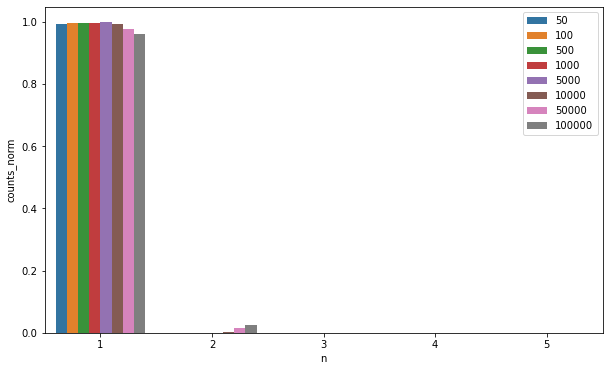

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

n_df = pd.DataFrame(columns=["time_window", "n", "counts"])

# Iterate over the time windows
for time_window, gamma_counts in gamma_counts_by_time_window.items():

    # compute how many ones there are in the gamma_counts list
    ones = gamma_counts.count(1)
    twos = gamma_counts.count(2)
    three = gamma_counts.count(3)
    four = gamma_counts.count(4)
    five = gamma_counts.count(5)
    
    n_df = n_df.append({"time_window": time_window, "n": 1, "counts": ones}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 2, "counts": twos}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 3, "counts": three}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 4, "counts": four}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 5, "counts": five}, ignore_index=True)
   
   
# normalize the counts to the total number of coincidences
for tw in time_windows:
    tot = labrb_coincidence[labrb_coincidence["time_window"] == tw].count()["id"]
    n_df.loc[n_df["time_window"] == tw, "counts_norm"] = n_df.loc[n_df["time_window"] == tw, "counts"] / tot * 2


ax = sns.barplot(x="n", y="counts_norm", hue="time_window", data=n_df, ax=ax) 
ax.legend()

plt.show()
    
    

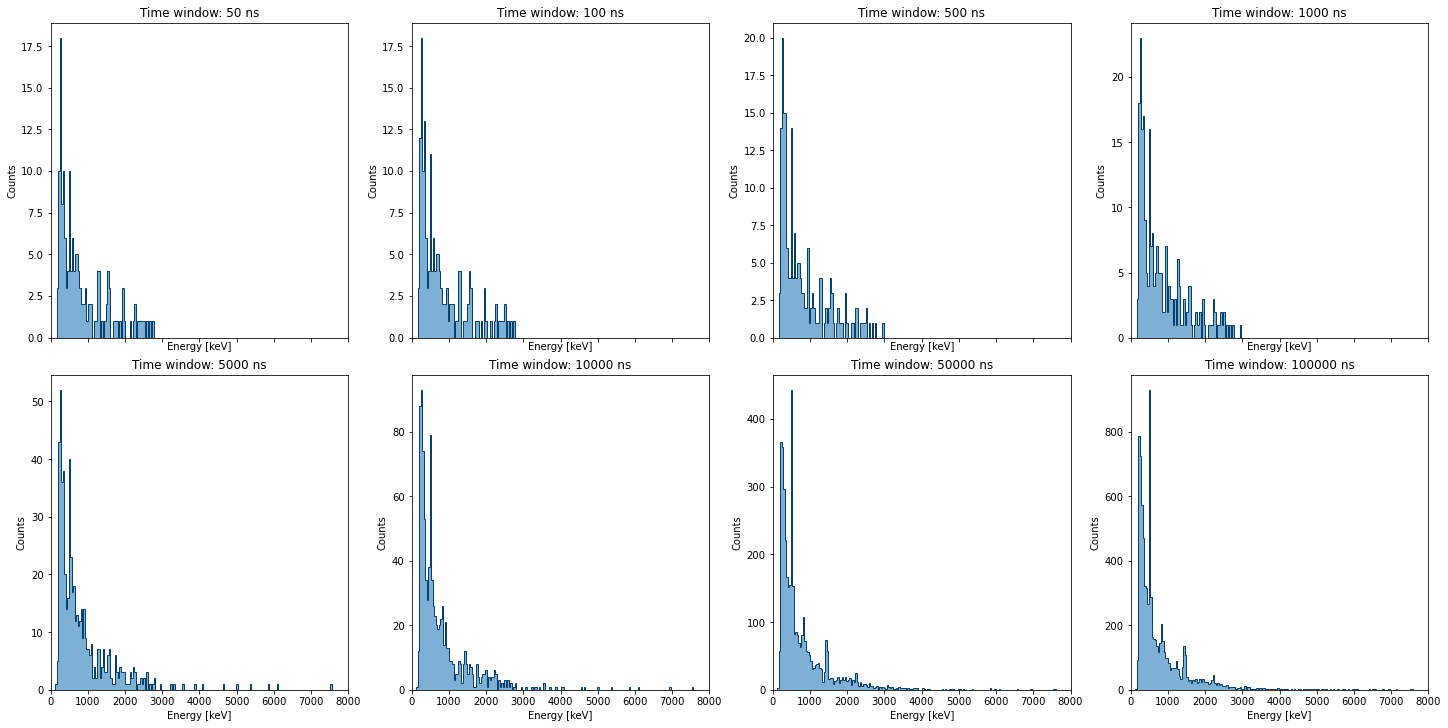

In [107]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True, sharex=True)

for i, tw in enumerate(time_windows):
    ax[i//4, i%4].hist(
        labrb_gamma[labrb_gamma["time_window"] == tw]["energy_calib"],
        bins      = np.linspace(0, 8000, 200), 
        histtype  = "stepfilled", 
        edgecolor = "#06416D", 
        facecolor = "#7eb0d5",
        label     = f"{tw} ns"
    )

    ax[i//4, i%4].set_xlim(0, 8000)
    ax[i//4, i%4].set_xlabel("Energy [keV]")
    ax[i//4, i%4].set_ylabel("Counts")

    ax[i//4, i%4].set_title(f"Time window: {int(tw)} ns")
    
    
fig.savefig("./plots/labrb_e_hist_coincidence_windows.png", dpi=300, facecolor="white")
plt.show()


# Gamma-neutron time distance

In [108]:
# compute time distance between a gamma and its closest neutron
def compute_time_distance(df):
    # Find the indices of the Neutron particles
    neutron_indices = df[df["Particle"] == "Neutron"].index
    # Initialize an empty list to store the counts of Gamma particles
    time_distances = []
    # Iterate over the indices of the Neutron particles
    for i in range(len(neutron_indices) - 1):
        # Get the start and end indices for the current time window
        start_index = neutron_indices[i]
        end_index = neutron_indices[i+1]
        # Count the number of Gamma particles in the current time window
        gamma_indices = df.loc[start_index:end_index, "Particle"].index[df.loc[start_index:end_index, "Particle"] == "Gamma"]
        # Iterate over the Gamma indices
        for gamma_index in gamma_indices:
            # Get the time difference between the Gamma and the Neutron
            time_distance = df.loc[gamma_index, "timestamp"] - df.loc[neutron_indices[i], "timestamp"]
            # Append the count to the list
            time_distances.append(time_distance)
    # Return the list of counts
    return time_distances

In [ ]:
time_w = 100

time_distance_a = compute_time_distance(labra_coincidence[labra_coincidence["time_window"] == time_w])
time_distance_b = compute_time_distance(labrb_coincidence[labrb_coincidence["time_window"] == time_w])

In [112]:
# conversion from ps to ns
time_distance_a = np.array(time_distance_a) / 1000
time_distance_b = np.array(time_distance_b) / 1000

In [118]:
# compute mean median and std
time_mean_a = np.mean(time_distance_a)
time_mean_b = np.mean(time_distance_b)
time_median_a = np.median(time_distance_a)
time_median_b = np.median(time_distance_b)
time_std_a = np.std(time_distance_a)
time_std_b = np.std(time_distance_b)

print(f"Mean time difference for {time_w} ns time window: {time_mean_a:.2f}ns (labra), {time_mean_b:.2f}ns (labrb)")
print(f"Median time difference for {time_w} ns time window: {time_median_a:.2f}ns (labra), {time_median_b:.2f}ns (labrb)")
print(f"Std time difference for {time_w} ns time window: {time_std_a:.2f}ns (labra), {time_std_b:.2f}ns (labrb)")

Mean time difference for 100 ns time window: 2.45ns (labra), 1.43ns (labrb)
Median time difference for 100 ns time window: 3.41ns (labra), 2.69ns (labrb)
Std time difference for 100 ns time window: 6.73ns (labra), 11.14ns (labrb)


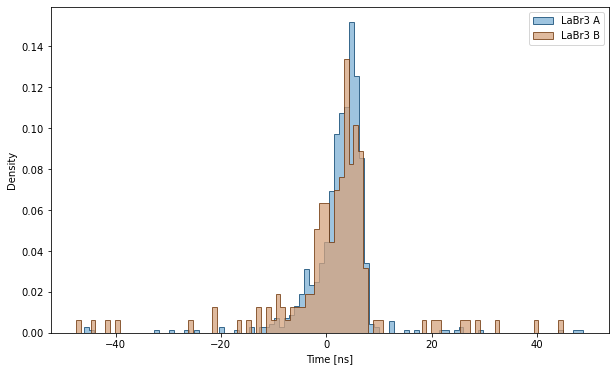

In [137]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(
    time_distance_a,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
ax.hist(
    time_distance_b,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# display mean and std
# ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
# ax.axvline(time_mean_a + time_std_a, color="#06416D", linestyle=":", label=f"Std: {time_std_a:.2f}ns")
# ax.axvline(time_mean_a - time_std_a, color="#06416D", linestyle=":")
# ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
# ax.axvline(time_mean_b + time_std_b, color="#6d3206", linestyle=":", label=f"Std: {time_std_b:.2f}ns")
# ax.axvline(time_mean_b - time_std_b, color="#6d3206", linestyle=":")

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

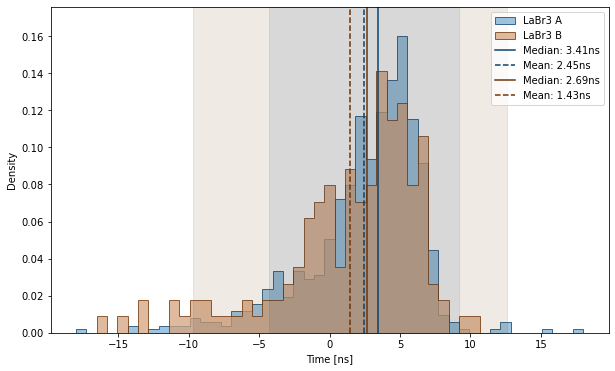

In [136]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mask_a = (time_distance_a > -18) & (time_distance_a < 18)
mask_b = (time_distance_b > -18) & (time_distance_b < 18)

bins = np.linspace(-18, 18, 50)

ha, _, _ = ax.hist(
    time_distance_a[mask_a],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
hb, _, _ = ax.hist(
    time_distance_b[mask_b],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# find the maximum of the histogram
h_max = max(ha.max(), hb.max())
h_min = 0

hd = h_max  + (h_max - h_min) * 0.1

# display mean and std
ax.axvline(time_median_a, color="#06416D", linestyle="-", label=f"Median: {time_median_a:.2f}ns")
ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_a - time_std_a, time_mean_a + time_std_a, color="#06416D", alpha=0.1)
ax.axvline(time_median_b, color="#6d3206", linestyle="-", label=f"Median: {time_median_b:.2f}ns")
ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_b - time_std_b, time_mean_b + time_std_b, color="#6d3206", alpha=0.1)
# ax.set_xlim(-18, 18)

ax.set_ylim(h_min, hd)

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

In [138]:
time_w = 50

time_distance_a = compute_time_distance(labra_coincidence[labra_coincidence["time_window"] == time_w])
time_distance_b = compute_time_distance(labrb_coincidence[labrb_coincidence["time_window"] == time_w])

In [139]:
# conversion from ps to ns
time_distance_a = np.array(time_distance_a) / 1000
time_distance_b = np.array(time_distance_b) / 1000

In [140]:
# compute mean median and std
time_mean_a = np.mean(time_distance_a)
time_mean_b = np.mean(time_distance_b)
time_median_a = np.median(time_distance_a)
time_median_b = np.median(time_distance_b)
time_std_a = np.std(time_distance_a)
time_std_b = np.std(time_distance_b)

print(f"Mean time difference for {time_w} ns time window: {time_mean_a:.2f}ns (labra), {time_mean_b:.2f}ns (labrb)")
print(f"Median time difference for {time_w} ns time window: {time_median_a:.2f}ns (labra), {time_median_b:.2f}ns (labrb)")
print(f"Std time difference for {time_w} ns time window: {time_std_a:.2f}ns (labra), {time_std_b:.2f}ns (labrb)")

Mean time difference for 50 ns time window: 2.50ns (labra), 1.53ns (labrb)
Median time difference for 50 ns time window: 3.41ns (labra), 2.66ns (labrb)
Std time difference for 50 ns time window: 4.58ns (labra), 6.13ns (labrb)


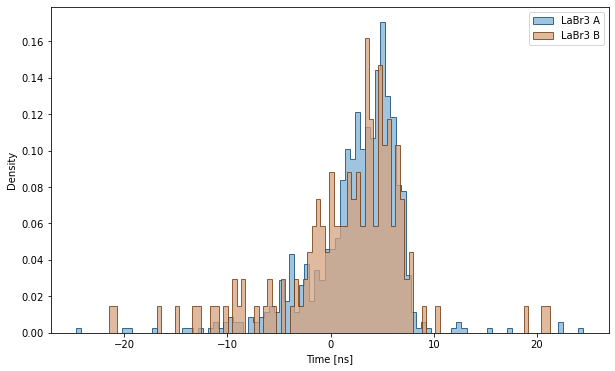

In [141]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(
    time_distance_a,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
ax.hist(
    time_distance_b,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# display mean and std
# ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
# ax.axvline(time_mean_a + time_std_a, color="#06416D", linestyle=":", label=f"Std: {time_std_a:.2f}ns")
# ax.axvline(time_mean_a - time_std_a, color="#06416D", linestyle=":")
# ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
# ax.axvline(time_mean_b + time_std_b, color="#6d3206", linestyle=":", label=f"Std: {time_std_b:.2f}ns")
# ax.axvline(time_mean_b - time_std_b, color="#6d3206", linestyle=":")

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

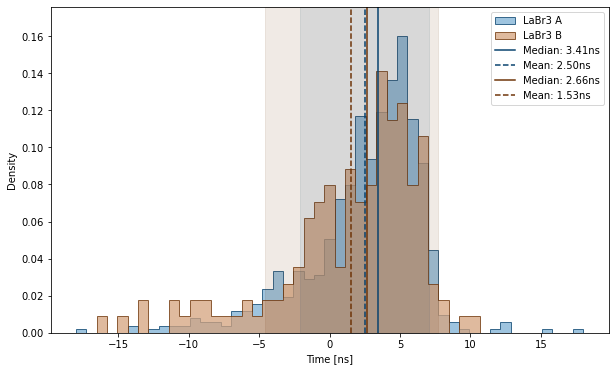

In [142]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mask_a = (time_distance_a > -18) & (time_distance_a < 18)
mask_b = (time_distance_b > -18) & (time_distance_b < 18)

bins = np.linspace(-18, 18, 50)

ha, _, _ = ax.hist(
    time_distance_a[mask_a],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
hb, _, _ = ax.hist(
    time_distance_b[mask_b],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# find the maximum of the histogram
h_max = max(ha.max(), hb.max())
h_min = 0

hd = h_max  + (h_max - h_min) * 0.1

# display mean and std
ax.axvline(time_median_a, color="#06416D", linestyle="-", label=f"Median: {time_median_a:.2f}ns")
ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_a - time_std_a, time_mean_a + time_std_a, color="#06416D", alpha=0.1)
ax.axvline(time_median_b, color="#6d3206", linestyle="-", label=f"Median: {time_median_b:.2f}ns")
ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_b - time_std_b, time_mean_b + time_std_b, color="#6d3206", alpha=0.1)
# ax.set_xlim(-18, 18)

ax.set_ylim(h_min, hd)

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

In [143]:
time_w = 5000

time_distance_a = compute_time_distance(labra_coincidence[labra_coincidence["time_window"] == time_w])
time_distance_b = compute_time_distance(labrb_coincidence[labrb_coincidence["time_window"] == time_w])

In [144]:
# conversion from ps to ns
time_distance_a = np.array(time_distance_a) / 1000
time_distance_b = np.array(time_distance_b) / 1000

In [145]:
# compute mean median and std
time_mean_a = np.mean(time_distance_a)
time_mean_b = np.mean(time_distance_b)
time_median_a = np.median(time_distance_a)
time_median_b = np.median(time_distance_b)
time_std_a = np.std(time_distance_a)
time_std_b = np.std(time_distance_b)

print(f"Mean time difference for {time_w} ns time window: {time_mean_a:.2f}ns (labra), {time_mean_b:.2f}ns (labrb)")
print(f"Median time difference for {time_w} ns time window: {time_median_a:.2f}ns (labra), {time_median_b:.2f}ns (labrb)")
print(f"Std time difference for {time_w} ns time window: {time_std_a:.2f}ns (labra), {time_std_b:.2f}ns (labrb)")

Mean time difference for 5000 ns time window: 43.99ns (labra), 9.12ns (labrb)
Median time difference for 5000 ns time window: 3.67ns (labra), 2.83ns (labrb)
Std time difference for 5000 ns time window: 931.45ns (labra), 1223.33ns (labrb)


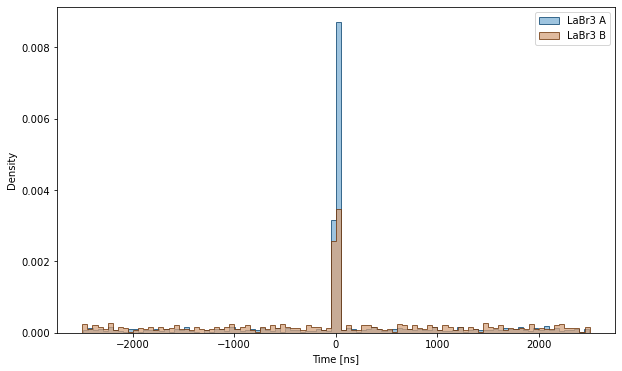

In [146]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(
    time_distance_a,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
ax.hist(
    time_distance_b,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# display mean and std
# ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
# ax.axvline(time_mean_a + time_std_a, color="#06416D", linestyle=":", label=f"Std: {time_std_a:.2f}ns")
# ax.axvline(time_mean_a - time_std_a, color="#06416D", linestyle=":")
# ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
# ax.axvline(time_mean_b + time_std_b, color="#6d3206", linestyle=":", label=f"Std: {time_std_b:.2f}ns")
# ax.axvline(time_mean_b - time_std_b, color="#6d3206", linestyle=":")

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

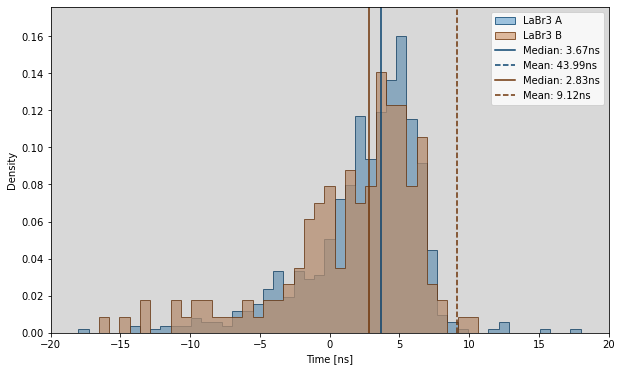

In [148]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mask_a = (time_distance_a > -18) & (time_distance_a < 18)
mask_b = (time_distance_b > -18) & (time_distance_b < 18)

bins = np.linspace(-18, 18, 50)

ha, _, _ = ax.hist(
    time_distance_a[mask_a],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
hb, _, _ = ax.hist(
    time_distance_b[mask_b],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# find the maximum of the histogram
h_max = max(ha.max(), hb.max())
h_min = 0

hd = h_max  + (h_max - h_min) * 0.1

# display mean and std
ax.axvline(time_median_a, color="#06416D", linestyle="-", label=f"Median: {time_median_a:.2f}ns")
ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_a - time_std_a, time_mean_a + time_std_a, color="#06416D", alpha=0.1)
ax.axvline(time_median_b, color="#6d3206", linestyle="-", label=f"Median: {time_median_b:.2f}ns")
ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_b - time_std_b, time_mean_b + time_std_b, color="#6d3206", alpha=0.1)
# ax.set_xlim(-18, 18)

ax.set_ylim(h_min, hd)

ax.set_xlim(-20, 20)

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

In [149]:
time_w = 500

time_distance_a = compute_time_distance(labra_coincidence[labra_coincidence["time_window"] == time_w])
time_distance_b = compute_time_distance(labrb_coincidence[labrb_coincidence["time_window"] == time_w])

In [150]:
# conversion from ps to ns
time_distance_a = np.array(time_distance_a) / 1000
time_distance_b = np.array(time_distance_b) / 1000

In [151]:
# compute mean median and std
time_mean_a = np.mean(time_distance_a)
time_mean_b = np.mean(time_distance_b)
time_median_a = np.median(time_distance_a)
time_median_b = np.median(time_distance_b)
time_std_a = np.std(time_distance_a)
time_std_b = np.std(time_distance_b)

print(f"Mean time difference for {time_w} ns time window: {time_mean_a:.2f}ns (labra), {time_mean_b:.2f}ns (labrb)")
print(f"Median time difference for {time_w} ns time window: {time_median_a:.2f}ns (labra), {time_median_b:.2f}ns (labrb)")
print(f"Std time difference for {time_w} ns time window: {time_std_a:.2f}ns (labra), {time_std_b:.2f}ns (labrb)")

Mean time difference for 500 ns time window: 3.07ns (labra), -3.26ns (labrb)
Median time difference for 500 ns time window: 3.44ns (labra), 2.62ns (labrb)
Std time difference for 500 ns time window: 35.10ns (labra), 61.74ns (labrb)


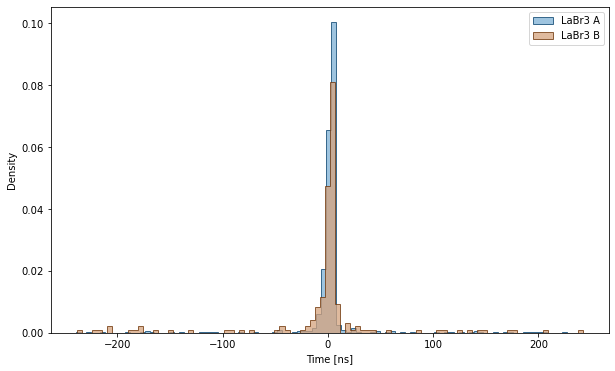

In [152]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(
    time_distance_a,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
ax.hist(
    time_distance_b,
    bins      = 100,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# display mean and std
# ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
# ax.axvline(time_mean_a + time_std_a, color="#06416D", linestyle=":", label=f"Std: {time_std_a:.2f}ns")
# ax.axvline(time_mean_a - time_std_a, color="#06416D", linestyle=":")
# ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
# ax.axvline(time_mean_b + time_std_b, color="#6d3206", linestyle=":", label=f"Std: {time_std_b:.2f}ns")
# ax.axvline(time_mean_b - time_std_b, color="#6d3206", linestyle=":")

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()

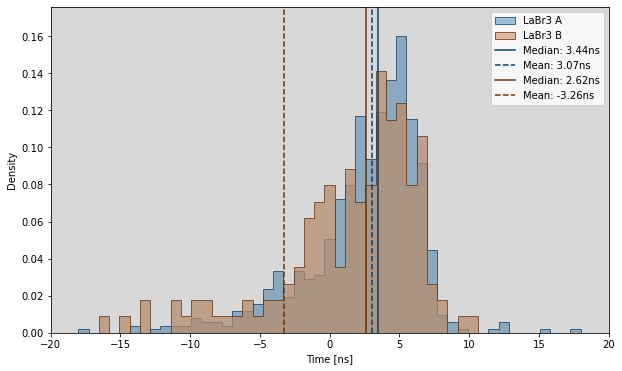

In [154]:
# Plot an histogram of the time distances
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mask_a = (time_distance_a > -18) & (time_distance_a < 18)
mask_b = (time_distance_b > -18) & (time_distance_b < 18)

bins = np.linspace(-18, 18, 50)

ha, _, _ = ax.hist(
    time_distance_a[mask_a],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#06416D", 
    facecolor = "#7eb0d5",
    label     = "LaBr3 A",
    density   = True,
    alpha     = 0.75
)
hb, _, _ = ax.hist(
    time_distance_b[mask_b],
    bins      = bins,
    histtype  = "stepfilled", 
    edgecolor = "#6d3206", 
    facecolor = "#d5a37e",
    label     = "LaBr3 B",
    density   = True,
    alpha     = 0.75
)

# find the maximum of the histogram
h_max = max(ha.max(), hb.max())
h_min = 0

hd = h_max  + (h_max - h_min) * 0.1

# display mean and std
ax.axvline(time_median_a, color="#06416D", linestyle="-", label=f"Median: {time_median_a:.2f}ns")
ax.axvline(time_mean_a, color="#06416D", linestyle="--", label=f"Mean: {time_mean_a:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_a - time_std_a, time_mean_a + time_std_a, color="#06416D", alpha=0.1)
ax.axvline(time_median_b, color="#6d3206", linestyle="-", label=f"Median: {time_median_b:.2f}ns")
ax.axvline(time_mean_b, color="#6d3206", linestyle="--", label=f"Mean: {time_mean_b:.2f}ns")
ax.fill_betweenx([h_min, hd], time_mean_b - time_std_b, time_mean_b + time_std_b, color="#6d3206", alpha=0.1)
# ax.set_xlim(-18, 18)

ax.set_ylim(h_min, hd)
ax.set_xlim(-20, 20)

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Density")
ax.legend()
plt.show()